In [61]:
# ============================================
# 0) Setup (installs optional)
# ============================================

# If needed (fresh env), uncomment:
# !pip -q install chronos-forecasting yfinance pandas-datareader matplotlib

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from typing import Sequence, Optional, Dict, Any, Tuple

from chronos import BaseChronosPipeline


In [62]:
# ============================================
# 1) Data loaders
# ============================================

def load_prices_yfinance(
    ticker: str,
    start: str = "1990-01-01",
    end: Optional[str] = None,
    interval: str = "1d",
    auto_adjust: bool = True,
) -> pd.DataFrame:
    import yfinance as yf

    df = yf.download(
        ticker,
        start=start,
        end=end,
        interval=interval,
        auto_adjust=auto_adjust,
        progress=False,
        group_by="column",
    )

    # Flatten MultiIndex columns if they appear
    if isinstance(df.columns, pd.MultiIndex):
        # common patterns: (field, ticker) or (ticker, field)
        lv0 = df.columns.get_level_values(0)
        lv1 = df.columns.get_level_values(1)
        if "Close" in lv0:
            df.columns = lv0
        elif "Close" in lv1:
            df.columns = lv1
        else:
            df.columns = ["_".join(map(str, c)).strip() for c in df.columns]

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df.index.name = "date"
    return df


def load_fred_series(
    fred_ids: Sequence[str],
    start: str = "1990-01-01",
    end: Optional[str] = None,
) -> pd.DataFrame:
    from pandas_datareader import data as web
    out = web.DataReader(list(fred_ids), "fred", start=start, end=end)
    out.index = pd.to_datetime(out.index)
    out = out.sort_index()
    out.index.name = "date"
    return out
def build_macro_covariates_fred(
    start: str,
    end: Optional[str],
    freq: str,
    release_lag: int = 1,
    ffill: bool = True,
) -> pd.DataFrame:
    """
    Builds a large macro panel from FRED and returns it resampled to `freq`,
    forward-filled, and shifted by `release_lag` periods to reduce look-ahead.

    You can add/remove series here freely.
    """

    # Rates, spreads, inflation, labor, growth, risk, volatility proxies
    fred_ids = [
        # Short/long rates
        "TB3MS",      # 3M T-bill (monthly)
        "DGS1",       # 1Y Treasury (daily)
        "DGS2",       # 2Y Treasury (daily)
        "DGS5",       # 5Y Treasury (daily)
        "DGS10",      # 10Y Treasury (daily)

        # Term spreads
        "T10Y2Y",     # 10Y - 2Y (daily)
        "T10Y3M",     # 10Y - 3M (daily)

        # Credit spreads
        "BAA10YM",    # BAA - 10Y (monthly-ish)
        "AAA10YM",    # AAA - 10Y
        "BAMLH0A0HYM2",# High yield OAS (daily)

        # Inflation / price level
        "CPIAUCSL",   # CPI (monthly)
        "CPILFESL",   # Core CPI (monthly)

        # Activity / labor
        "UNRATE",     # unemployment (monthly)
        "INDPRO",     # industrial production (monthly)

        # Financial conditions / stress
        "NFCI",       # Chicago Fed NFCI (weekly)
        "STLFSI4",    # St. Louis Fed Financial Stress Index (weekly)

        # Equity vol proxy
        "VIXCLS",     # VIX (daily)
    ]

    fred = load_fred_series(fred_ids, start=start, end=end)

    # resample to target freq
    fred = fred.resample(freq).last()

    if ffill:
        fred = fred.ffill()

    # release lag to mimic real-time availability
    if release_lag and release_lag > 0:
        fred = fred.shift(release_lag)

    # engineered transforms (helpful, stable)
    out = pd.DataFrame(index=fred.index)

    # Levels
    out["rf_level"] = fred["TB3MS"]
    out["y1"] = fred["DGS1"]
    out["y2"] = fred["DGS2"]
    out["y5"] = fred["DGS5"]
    out["y10"] = fred["DGS10"]

    out["tms_10y3m"] = fred["T10Y3M"]
    out["tms_10y2y"] = fred["T10Y2Y"]

    out["cs_baa10y"] = fred["BAA10YM"]
    out["cs_aaa10y"] = fred["AAA10YM"]
    out["hy_oas"] = fred["BAMLH0A0HYM2"]

    out["unrate"] = fred["UNRATE"]
    out["indpro"] = fred["INDPRO"]

    out["nfci"] = fred["NFCI"]
    out["stlfsi"] = fred["STLFSI4"]

    out["vix"] = fred["VIXCLS"]

    # Changes (rates & macro often matter in changes)
    for c in ["rf_level", "y2", "y10", "tms_10y3m", "cs_baa10y", "hy_oas", "unrate", "vix", "nfci", "stlfsi"]:
        if c in out.columns:
            out[c + "_chg1"] = out[c].diff(1)
            out[c + "_chg4"] = out[c].diff(4)  # ~1 month for weekly, ~1 year for monthly if freq=MS adjust later

    # Inflation (approx log change)
    if "CPIAUCSL" in fred.columns:
        cpi = fred["CPIAUCSL"]
        out["infl"] = np.log(cpi).diff(1) * 100.0
    if "CPILFESL" in fred.columns:
        core = fred["CPILFESL"]
        out["infl_core"] = np.log(core).diff(1) * 100.0

    return out


In [63]:
# ============================================
# 2) Helpers: frequency, resampling, features
# ============================================

def infer_periods_per_year(freq: str) -> int:
    f = freq.upper()
    if f in ["B", "D"]:
        return 252
    if f.startswith("W"):
        return 52
    if f in ["MS", "M"]:
        return 12
    if f in ["QS", "Q"]:
        return 4
    return 12


def align_and_resample(df: pd.DataFrame, freq: str, how: str = "last") -> pd.DataFrame:
    if how == "last":
        return df.resample(freq).last()
    if how == "mean":
        return df.resample(freq).mean()
    raise ValueError("how must be 'last' or 'mean'")


def make_technical_covariates(price: pd.Series) -> pd.DataFrame:
    px = price.astype(float)
    ret1 = px.pct_change()
    mom_5 = px.pct_change(5)
    mom_21 = px.pct_change(21)
    vol_21 = ret1.rolling(21).std()
    ma_20 = px.rolling(20).mean()
    ma_100 = px.rolling(100).mean()

    feats = pd.DataFrame(
        {
            "ret1": ret1,
            "mom_5": mom_5,
            "mom_21": mom_21,
            "vol_21": vol_21,
            "ma20_gap": (px / ma_20 - 1.0),
            "ma100_gap": (px / ma_100 - 1.0),
        },
        index=px.index,
    )
    return feats


def make_calendar_covariates(idx: pd.DatetimeIndex) -> pd.DataFrame:
    dt = pd.DatetimeIndex(idx)
    dow = dt.dayofweek.values
    moy = dt.month.values

    dow_sin = np.sin(2 * np.pi * dow / 7.0)
    dow_cos = np.cos(2 * np.pi * dow / 7.0)
    moy_sin = np.sin(2 * np.pi * (moy - 1) / 12.0)
    moy_cos = np.cos(2 * np.pi * (moy - 1) / 12.0)

    return pd.DataFrame(
        {
            "dow_sin": dow_sin,
            "dow_cos": dow_cos,
            "moy_sin": moy_sin,
            "moy_cos": moy_cos,
        },
        index=dt,
    )

def make_technical_covariates_rich(price: pd.Series) -> pd.DataFrame:
    """
    Rich technical panel at multiple horizons.
    Built only from prices up to t (no look-ahead).
    """
    px = price.astype(float)
    ret1 = px.pct_change()

    feats = pd.DataFrame(index=px.index)

    # Multi-horizon momentum
    for k in [1, 2, 4, 8, 13, 26, 52]:
        feats[f"mom_{k}"] = px.pct_change(k)

    # Multi-horizon vol
    for w in [4, 8, 13, 26, 52]:
        feats[f"vol_{w}"] = ret1.rolling(w).std()

    # Drawdown / distance from highs
    for w in [13, 26, 52]:
        roll_max = px.rolling(w).max()
        feats[f"dd_{w}"] = (px / roll_max - 1.0)

    # Moving average gaps
    for w in [10, 20, 50, 100, 200]:
        ma = px.rolling(w).mean()
        feats[f"ma{w}_gap"] = (px / ma - 1.0)

    # Skew/kurt style moments of returns (rough risk regime proxies)
    for w in [13, 26, 52]:
        r = ret1.rolling(w)
        feats[f"meanret_{w}"] = r.mean()
        feats[f"varret_{w}"] = r.var()

    return feats


In [64]:
def make_calendar_covariates(idx: pd.DatetimeIndex) -> pd.DataFrame:
    dt = pd.DatetimeIndex(idx)
    dow = dt.dayofweek.values
    moy = dt.month.values

    return pd.DataFrame(
        {
            "dow_sin": np.sin(2 * np.pi * dow / 7.0),
            "dow_cos": np.cos(2 * np.pi * dow / 7.0),
            "moy_sin": np.sin(2 * np.pi * (moy - 1) / 12.0),
            "moy_cos": np.cos(2 * np.pi * (moy - 1) / 12.0),
        },
        index=dt,
    )
def build_dataset_spy_rich_real(
    start: str = "1995-01-01",
    end: Optional[str] = None,
    freq: str = "W-FRI",
    macro_release_lag: int = 1,
    ffill_macro: bool = True,
) -> pd.DataFrame:
    """
    REAL setting, rich covariate panel.
    Target at t is FORWARD excess return (t -> t+1).
    Covariates at t are known at t (macro is lagged to reduce look-ahead).
    """

    # --- prices
    px = load_prices_yfinance("SPY", start=start, end=end, interval="1d", auto_adjust=True)
    if "Close" not in px.columns:
        raise ValueError(f"Expected 'Close' from yfinance, got: {list(px.columns)}")

    close = px["Close"]
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]
    close = close.astype(float).rename("price")

    price_df = close.to_frame()
    price_df.index = pd.to_datetime(price_df.index)
    price_df = price_df.sort_index()
    price_df.index.name = "date"
    price_df = price_df.resample(freq).last()

    price = price_df["price"].astype(float)

    # --- macro covariates
    macro = build_macro_covariates_fred(
        start=start, end=end, freq=freq, release_lag=macro_release_lag, ffill=ffill_macro
    )

    # --- risk-free per period (from TB3MS level, annual %)
    ppy = infer_periods_per_year(freq)
    rf_t = (macro["rf_level"] / 100.0) / ppy
    rf_t = rf_t.rename("Rfree")

    # --- target: forward return t->t+1 minus rf_{t+1}
    mkt_ret_fwd = price.pct_change().shift(-1).rename("mkt_ret_fwd")
    rf_fwd = rf_t.shift(-1).rename("rf_fwd")
    equity_premium = (mkt_ret_fwd - rf_fwd).rename("equity_premium")

    # --- technical + calendar
    tech = make_technical_covariates_rich(price)
    cal = make_calendar_covariates(price_df.index)

    # combine
    df = pd.concat(
        [equity_premium, rf_t, price, macro, tech, cal],
        axis=1
    )

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Important: drop rows missing target; keep others (Chronos can handle NaNs poorly, so we’ll drop later too)
    df = df.dropna(subset=["equity_premium", "Rfree", "price"])

    return df
def select_and_clean_covariates(
    df: pd.DataFrame,
    target_col: str,
    min_non_na_share: float = 0.98,
    drop_initial: int = 0,
) -> Tuple[pd.DataFrame, Sequence[str]]:
    """
    Keeps covariates that have enough non-NA coverage, and returns the cleaned df + cov list.
    """
    d = df.copy()
    if drop_initial > 0:
        d = d.iloc[drop_initial:].copy()

    covs = [c for c in d.columns if c not in [target_col]]
    # Remove obvious non-covariates if present
    covs = [c for c in covs if c not in ["y_true", "y_pred", "y_lo", "y_hi", "HA"]]

    ok_covs = []
    for c in covs:
        share = d[c].notna().mean()
        if share >= min_non_na_share:
            ok_covs.append(c)

    # Drop rows where any selected covariate is NA (Chronos covariate arrays must be aligned)
    d = d.dropna(subset=[target_col] + ok_covs)

    return d, ok_covs


In [65]:
# ============================================
# 3) Real-data dataset builder (GW-style timing)
#    Features at t -> predict excess return from t -> t+1
#    Macro is optionally lagged to avoid publication look-ahead
# ============================================

def build_dataset_spy_with_macro_and_tech_real(
    start: str = "1995-01-01",
    end: Optional[str] = None,
    freq: str = "W-FRI",          # "B", "W-FRI", "MS"
    macro_release_lag: int = 1,   # >=1 recommended for real-time-ish macro
    ffill_macro: bool = True,
) -> pd.DataFrame:
    """
    Output columns:
      - price (period-end)
      - Rfree (per-period decimal, aligned to t)
      - equity_premium (forward excess return: (t->t+1) market minus rf_{t+1})
      - macro covariates at time t (lagged for real-time)
      - technical covariates at time t (from prices up to t)
      - calendar covariates at time t (known)
    """

    # --- prices (daily -> resample)
    px = load_prices_yfinance("SPY", start=start, end=end, interval="1d", auto_adjust=True)
    if "Close" not in px.columns:
        raise ValueError(f"Expected 'Close' from yfinance, got columns: {list(px.columns)}")

    close = px["Close"]
    if isinstance(close, pd.DataFrame):  # just in case
        close = close.iloc[:, 0]
    close = close.astype(float).rename("price")

    price_df = close.to_frame()
    price_df.index = pd.to_datetime(price_df.index)
    price_df = price_df.sort_index()
    price_df.index.name = "date"
    price_df = align_and_resample(price_df, freq=freq, how="last")

    price = price_df["price"].astype(float)

    # --- macro (FRED)
    # TB3MS: annualized percent rate (monthly)
    # T10Y3M: term spread
    # BAA10YM: credit spread proxy
    fred = load_fred_series(["TB3MS", "T10Y3M", "BAA10YM"], start=start, end=end)
    fred = align_and_resample(fred, freq=freq, how="last")

    if ffill_macro:
        fred = fred.ffill()

    # lag macro to mimic publication lag / availability
    if macro_release_lag and macro_release_lag > 0:
        fred = fred.shift(macro_release_lag)

    # per-period rf approximation
    ppy = infer_periods_per_year(freq)
    rf_t = (fred["TB3MS"] / 100.0) / ppy
    rf_t = rf_t.rename("Rfree")

    # --- target (forward): return from t -> t+1, aligned at t
    mkt_ret_fwd = price.pct_change().shift(-1).rename("mkt_ret_fwd")
    rf_fwd = rf_t.shift(-1).rename("rf_fwd")
    equity_premium = (mkt_ret_fwd - rf_fwd).rename("equity_premium")

    # --- covariates at t
    tech = make_technical_covariates(price)
    cal = make_calendar_covariates(price_df.index)

    macro_cov = pd.DataFrame(
        {
            "tms": fred["T10Y3M"],
            "cs": fred["BAA10YM"],
            "rf_level": fred["TB3MS"],
        },
        index=price_df.index,
    )

    df = pd.concat(
        [
            equity_premium,
            rf_t,                # rf at t (for backtests / accounting)
            price_df["price"],
            macro_cov,
            tech,
            cal,
        ],
        axis=1,
    )

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Drop rows without target (forward return) and without the pieces you need
    df = df.dropna(subset=["equity_premium", "Rfree", "price"])

    # Final safety checks
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index is not DatetimeIndex.")
    if "price" not in df.columns:
        raise ValueError("'price' is not a column.")

    return df


In [66]:
# ============================================
# 4) OOS evaluation helpers (R^2 + block bootstrap CI)
# ============================================

def block_bootstrap_r2(
    trues: np.ndarray,
    preds: np.ndarray,
    bench: np.ndarray,
    B: int = 2000,
    block: int = 12,
    seed: int = 123,
) -> Tuple[float, Dict[str, float]]:
    rng = np.random.default_rng(seed)
    n = len(trues)
    if n < 2:
        return np.nan, {"mean": np.nan, "std": np.nan, "lower": np.nan, "upper": np.nan}

    if n < block * 2:
        block = 1

    def r2_oos(a, f, b):
        denom = np.sum((a - b) ** 2)
        return np.nan if denom == 0 else 1.0 - np.sum((a - f) ** 2) / denom

    r2_hat = r2_oos(trues, preds, bench)

    r2_star = []
    for _ in range(B):
        if block == 1:
            idx = rng.integers(0, n, size=n)
        else:
            starts = rng.integers(0, n - block + 1, size=int(np.ceil(n / block)))
            idx = np.concatenate([np.arange(s, s + block) for s in starts])[:n]
        r2_star.append(r2_oos(trues[idx], preds[idx], bench[idx]))

    r2_star = np.array(r2_star, float)
    lo = np.nanquantile(r2_star, 0.05)
    hi = np.nanquantile(r2_star, 0.95)

    stats = {
        "mean": float(np.nanmean(r2_star)),
        "std": float(np.nanstd(r2_star)),
        "lower": float(lo),
        "upper": float(hi),
    }
    return float(r2_hat), stats


def evaluate_oos(trues: np.ndarray, preds: np.ndarray, y_bench: np.ndarray, model_name: str = "Model") -> Tuple[float, Dict[str, float]]:
    r2, stats = block_bootstrap_r2(trues, preds, y_bench, B=2000, block=12, seed=123)
    print(f"[{model_name}] OOS R2 = {r2:.4f} | 90% boot CI [{stats['lower']:.4f}, {stats['upper']:.4f}]")
    return r2, stats


def ct_truncate(x: float, cutoff: float = 0.0) -> float:
    return max(x, cutoff)


def ct_eval_summary(trues: np.ndarray, preds: np.ndarray, cutoff: float = 0.0) -> Dict[str, float]:
    in_mkt = preds > cutoff
    share = float(np.mean(in_mkt))
    if np.any(in_mkt) and np.any(~in_mkt):
        spread = float(np.mean(trues[in_mkt]) - np.mean(trues[~in_mkt]))
    else:
        spread = np.nan
    return {"share_in_market": share, "timing_spread": spread}


In [67]:
# ============================================
# 5) Chronos-2 expanding OOS (real-time aligned)
#    Features at t -> predict target at t (which is forward return t->t+1)
#    Use cov_style="future" so the model sees covariates for time t
# ============================================

def chronos2_oos_real(
    data: pd.DataFrame,
    covariates: Sequence[str],
    target_col: str = "equity_premium",
    start_oos: str = "2005-01-01",
    ctx_min: int = 104,                 # weekly ~2y; daily ~252; monthly ~60
    ct_cutoff: bool = True,
    model_id: str = "amazon/chronos-2",
    ci: float = 0.90,
    context_length: Optional[int] = None,
    model_name: str = "Chronos-2 (real-aligned)",
    cov_style: str = "future",          # for real setting: covariates at t known; predict y(t)=return t->t+1
    quiet: bool = False,
) -> Tuple[pd.DataFrame, Dict[str, Any]]:

    df = data.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    needed = [target_col] + list(covariates)
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    y = df[target_col].astype("float32")
    X = df[list(covariates)].astype("float32")

    # device
    if torch.backends.mps.is_available():
        device_map = torch.device("mps")
    elif torch.cuda.is_available():
        device_map = torch.device("cuda")
    else:
        device_map = torch.device("cpu")
    torch_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

    print(f"[Chronos-2] Loading {model_id} | device={device_map} | cov_style={cov_style}")
    pipeline = BaseChronosPipeline.from_pretrained(
        model_id,
        device_map=device_map,
        torch_dtype=torch_dtype,
    )

    alpha = (1 - ci) / 2
    q_levels = [alpha, 0.5, 1 - alpha]

    def fit_predict_at(pos: int) -> Optional[Tuple[float, float, float]]:
        if pos < ctx_min:
            return None

        # context slice
        if context_length is not None and pos >= context_length:
            start = pos - context_length
        else:
            start = 0

        # We predict y at position pos (date_t), which is the forward return t->t+1 stored at t.
        # So at forecast time t, covariates at t are known and can be used as "future_covariates" for the next step.
        if cov_style == "future":
            # target history corresponds to y at times < t (aligned at their t)
            # We'll provide up to (t-1) inclusive
            target_hist = y.values[start:pos]  # y[start .. t-1]

            # past covariates: covs up to (t-1)
            past_covs = {c: X[c].values[start:pos] for c in covariates}

            # future covariates: covs at t (one-step)
            future_covs = {c: X[c].values[pos:pos+1] for c in covariates}

            entry = {"target": target_hist, "past_covariates": past_covs, "future_covariates": future_covs}

        elif cov_style == "past":
            # past-only: predict using covariates only up to t-1
            target_hist = y.values[start:pos]
            past_covs = {c: X[c].values[start:pos] for c in covariates}
            entry = {"target": target_hist, "past_covariates": past_covs}
        else:
            raise ValueError("cov_style must be 'future' or 'past'.")

        with torch.inference_mode():
            quantiles, mean_pred = pipeline.predict_quantiles(
                inputs=[entry],
                prediction_length=1,
                quantile_levels=q_levels,
            )

        mu = float(mean_pred[0][0, 0].item())
        lo = float(quantiles[0][0, 0, 0].item())
        hi = float(quantiles[0][0, 0, 2].item())
        return mu, lo, hi

    # OOS loop dates
    start_ts = pd.Timestamp(start_oos)
    loop_idx = df.index[df.index >= start_ts]

    preds_ct, preds_raw, trues, dates, HA, lo_list, hi_list = [], [], [], [], [], [], []
    truncated = 0

    for date_t in loop_idx:
        pos = df.index.get_loc(date_t)

        y_true = float(df.iloc[pos][target_col])
        if np.isnan(y_true):
            continue

        # require enough history of non-NA target
        if df.iloc[:pos][target_col].notna().sum() < ctx_min:
            continue

        out = fit_predict_at(pos)
        if out is None:
            continue

        y_hat, y_lo, y_hi = out
        if np.isnan(y_hat):
            continue

        preds_raw.append(y_hat)

        if ct_cutoff:
            if y_hat <= 0:
                truncated += 1
            y_hat_ct = ct_truncate(y_hat, cutoff=0.0)
        else:
            y_hat_ct = y_hat

        preds_ct.append(float(y_hat_ct))
        trues.append(float(y_true))
        dates.append(date_t)

        ha_t = float(df.iloc[:pos][target_col].dropna().mean())
        HA.append(ha_t)

        lo_list.append(y_lo)
        hi_list.append(y_hi)

        if (not quiet) and (len(preds_ct) % 50 == 0):
            print(f"{date_t.date()} | n={len(preds_ct)}")

    trues = np.asarray(trues, float)
    preds_ct = np.asarray(preds_ct, float)
    preds_raw = np.asarray(preds_raw, float)
    HA = np.asarray(HA, float)

    r2_ct, stats_ct = evaluate_oos(trues, preds_ct, HA, model_name=model_name + " (CT)")
    r2_raw, stats_raw = evaluate_oos(trues, preds_raw, HA, model_name=model_name + " (raw)")

    timing = ct_eval_summary(trues, preds_ct, cutoff=0.0)
    print(f"Negative raw forecasts: {truncated}/{len(preds_ct)} ({truncated/len(preds_ct)*100:.2f}%)")
    print(f"Timing summary (CT): {timing}")

    pred_df = pd.DataFrame(
        {
            "y_true": trues,
            "y_pred": preds_ct,
            "y_pred_raw": preds_raw,
            "y_lo": np.asarray(lo_list, float),
            "y_hi": np.asarray(hi_list, float),
            "HA": HA,
        },
        index=pd.DatetimeIndex(dates, name="date"),
    )

    summary = {
        "r2_ct": r2_ct,
        "stats_ct": stats_ct,
        "r2_raw": r2_raw,
        "stats_raw": stats_raw,
        "n_oos": int(len(pred_df)),
        "truncated_count": int(truncated),
        "timing": timing,
    }
    return pred_df, summary


In [68]:
# ============================================
# 6) Trading strategy code (exactly your functions)
# ============================================

def build_arith_excess_from_target(df, target_col, rf_col="Rfree", uselog=False):
    rf = df[rf_col].astype(float)
    y = df[target_col].astype(float)

    if not uselog:
        r_excess = y
    else:
        r_excess = (1.0 + rf) * np.expm1(y)

    return r_excess, rf


def convert_pred_to_arith_excess(pred, rf, uselog=False):
    pred = pred.astype(float)
    if not uselog:
        return pred
    else:
        return (1.0 + rf) * np.expm1(pred)


def backtest_timing_strategy(
    df,
    target_col="equity_premium",
    pred_col="y_pred",
    rf_col="Rfree",
    uselog=False,
    gamma=5.0,
    vol_window=60,
    w_min=0.0,
    w_max=1.5,
    lag=0,
):
    d = df.copy()

    r_excess, rf = build_arith_excess_from_target(d, target_col, rf_col=rf_col, uselog=uselog)

    pred = d[pred_col].astype(float)
    pred_excess = convert_pred_to_arith_excess(pred, rf=rf, uselog=uselog)

    var = r_excess.rolling(vol_window, min_periods=vol_window).var().shift(1)

    pred_excess = pred_excess.shift(lag)
    w = (pred_excess / (gamma * var)).clip(w_min, w_max)

    port_excess = w * r_excess
    port_total = rf + port_excess

    out = pd.DataFrame(index=d.index)
    out["rf"] = rf
    out["r_excess"] = r_excess
    out["pred_excess_used"] = pred_excess
    out["var"] = var
    out["w"] = w
    out["port_excess"] = port_excess
    out["port_total"] = port_total
    out["turnover"] = out["w"].diff().abs()
    out["mkt_total"] = rf + r_excess

    return out


def perf_stats(total_returns, excess_returns=None, periods_per_year=12):
    rt = total_returns.dropna()
    if len(rt) < 2:
        return {}

    wealth = (1 + rt).cumprod()
    total_ret = wealth.iloc[-1] - 1
    cagr = wealth.iloc[-1] ** (periods_per_year / len(rt)) - 1
    ann_vol = rt.std(ddof=0) * np.sqrt(periods_per_year)

    if excess_returns is None:
        excess_returns = rt
    re = excess_returns.dropna()

    sharpe = np.nan
    if len(re) > 1:
        std = re.std(ddof=0)
        sharpe = (re.mean() / std) * np.sqrt(periods_per_year) if std > 0 else np.nan

    peak = wealth.cummax()
    max_dd = (wealth / peak - 1).min()

    return {
        "TotalReturn": float(total_ret),
        "CAGR": float(cagr),
        "AnnVol": float(ann_vol),
        "Sharpe": float(sharpe) if np.isfinite(sharpe) else np.nan,
        "MaxDrawdown": float(max_dd),
    }


def ann_utility(excess_returns, gamma=5.0, periods_per_year=12):
    r = excess_returns.dropna()
    if len(r) < 2:
        return np.nan

    mean_r = r.mean()
    var_r = r.var(ddof=0)

    u = mean_r - (gamma / 2.0) * var_r
    return float(periods_per_year * u)


def compare_strategies(df_bt, r_excess_col="r_excess", gamma=5.0, vol_window=60, periods_per_year=12):
    r_excess = df_bt[r_excess_col].astype(float)
    var = df_bt["var"].astype(float)
    rf = df_bt["rf"].astype(float)

    mu = r_excess.expanding(min_periods=vol_window).mean().shift(1)

    w_ha = (mu / (gamma * var)).clip(0.0, 1.5)
    w_50 = pd.Series(0.5, index=df_bt.index)
    w_100 = pd.Series(1.0, index=df_bt.index)

    ha_excess = w_ha * r_excess
    s50_excess = w_50 * r_excess
    s100_excess = w_100 * r_excess

    ha_total = rf + ha_excess
    s50_total = rf + s50_excess
    s100_total = rf + s100_excess

    R = pd.DataFrame(
        {
            "Model": df_bt["port_total"].astype(float),
            "HA": ha_total.astype(float),
            "W50": s50_total.astype(float),
            "W100": s100_total.astype(float),
        }
    ).dropna()

    RE = pd.DataFrame(
        {
            "Model": df_bt["port_excess"].astype(float),
            "HA": ha_excess.astype(float),
            "W50": s50_excess.astype(float),
            "W100": s100_excess.astype(float),
        }
    ).loc[R.index].dropna()

    common_idx = R.index.intersection(RE.index)
    R = R.loc[common_idx]
    RE = RE.loc[common_idx]

    rows = []
    for col in R.columns:
        stats = perf_stats(R[col], RE[col], periods_per_year=periods_per_year)
        stats["CEV"] = ann_utility(RE[col], gamma=gamma, periods_per_year=periods_per_year)
        stats["Strategy"] = col
        rows.append(stats)

    summary = pd.DataFrame(rows).set_index("Strategy")

    summary["Δu vs HA"] = np.nan
    summary["Δu vs 50%"] = np.nan
    summary["Δu vs 100%"] = np.nan
    summary.loc["Model", "Δu vs HA"] = summary.loc["Model", "CEV"] - summary.loc["HA", "CEV"]
    summary.loc["Model", "Δu vs 50%"] = summary.loc["Model", "CEV"] - summary.loc["W50", "CEV"]
    summary.loc["Model", "Δu vs 100%"] = summary.loc["Model", "CEV"] - summary.loc["W100", "CEV"]

    return summary


In [69]:
# ============================================
# 7) Run end-to-end (real setting)
# ============================================

freq = "M"   # try "W-FRI","B" or "MS"

df = build_dataset_spy_with_macro_and_tech_real(
    start="1940-01-01",
    end=None,
    freq=freq,
    macro_release_lag=1,   # real-time-ish
    ffill_macro=True,
)

print(df.shape)
print(df.columns.tolist())
df.tail()


/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_54956/2922613972.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df.resample(freq).last()


(397, 16)
['equity_premium', 'Rfree', 'price', 'tms', 'cs', 'rf_level', 'ret1', 'mom_5', 'mom_21', 'vol_21', 'ma20_gap', 'ma100_gap', 'dow_sin', 'dow_cos', 'moy_sin', 'moy_cos']


/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_54956/2922613972.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df.resample(freq).last()


,equity_premium,Rfree,price,tms,cs,rf_level,ret1,mom_5,mom_21,vol_21,ma20_gap,ma100_gap,dow_sin,dow_cos,moy_sin,moy_cos
date,,,,,,,,,,,,,,,,
2025-09-30,0.020571,0.003433,664.217285,0.00,1.74,4.12,0.035620,0.208212,0.431986,0.032468,0.169214,0.769616,0.781831,0.623490,-0.866025,-5.000000e-01
2025-10-31,-0.001233,0.003267,680.050537,0.14,1.71,3.92,0.023837,0.163869,0.443137,0.032491,0.177985,0.789450,-0.433884,-0.900969,-1.000000,-1.836970e-16
2025-11-30,-0.002353,0.003183,681.376587,0.22,1.68,3.82,0.001950,0.109144,0.374234,0.031698,0.163221,0.771232,-0.781831,0.623490,-0.866025,5.000000e-01
2025-12-31,0.011746,0.003150,681.919983,0.14,1.77,3.78,0.000797,0.085038,0.331779,0.031608,0.145519,0.751443,0.974928,-0.222521,-0.500000,8.660254e-01
2026-01-31,-0.008784,0.002992,691.969971,0.51,1.76,3.59,0.014738,0.078891,0.408183,0.029038,0.145495,0.755996,-0.974928,-0.222521,0.000000,1.000000e+00


In [70]:
# Choose covariates (start small; add later)
# In "real setting", we use cov_style="future" so covariates at t are provided to predict y(t)=t->t+1.
covs = [
    "tms", "cs", "rf_level",    # macro (lagged)
    "mom_21", "vol_21",         # technical
    "dow_sin", "dow_cos", "moy_sin", "moy_cos",  # calendar (known)
]

# ctx_min suggestion by freq
if freq.upper() in ["MS", "M"]:
    ctx_min = 60
elif freq.upper().startswith("W"):
    ctx_min = 104
else:
    ctx_min = 252

pred_df, summary = chronos2_oos_real(
    data=df,
    covariates=covs,
    target_col="equity_premium",
    start_oos="1965-01-01",
    ctx_min=ctx_min,
    ct_cutoff=True,
    model_id="amazon/chronos-2",
    ci=0.90,
    context_length=None,
    model_name=f"Chronos-2 SPY real ({freq})",
    cov_style="future",
    quiet=False,
)

summary


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[Chronos-2] Loading amazon/chronos-2 | device=mps | cov_style=future


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


2002-02-28 | n=50
2006-04-30 | n=100
2010-06-30 | n=150
2014-08-31 | n=200
2018-10-31 | n=250
2022-12-31 | n=300
[Chronos-2 SPY real (M) (CT)] OOS R2 = -0.1314 | 90% boot CI [-0.2214, -0.0532]
[Chronos-2 SPY real (M) (raw)] OOS R2 = -0.1699 | 90% boot CI [-0.2608, -0.0836]
Negative raw forecasts: 56/337 (16.62%)
Timing summary (CT): {'share_in_market': 0.8338278931750742, 'timing_spread': -0.00876433309238851}


{'r2_ct': -0.13144237454303376,
 'stats_ct': {'mean': -0.1334748556148312,
  'std': 0.05127507848815575,
  'lower': -0.2214392518106328,
  'upper': -0.05319444712664943},
 'r2_raw': -0.16987514504583356,
 'stats_raw': {'mean': -0.16943627314716117,
  'std': 0.054059382660409536,
  'lower': -0.26081632214647055,
  'upper': -0.08359424788221628},
 'n_oos': 337,
 'truncated_count': 56,
 'timing': {'share_in_market': 0.8338278931750742,
  'timing_spread': -0.00876433309238851}}

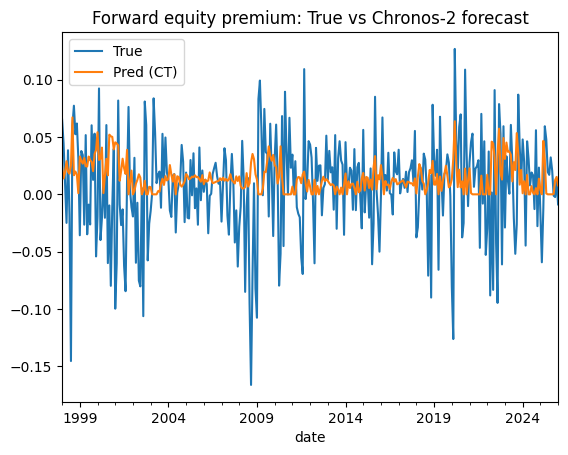

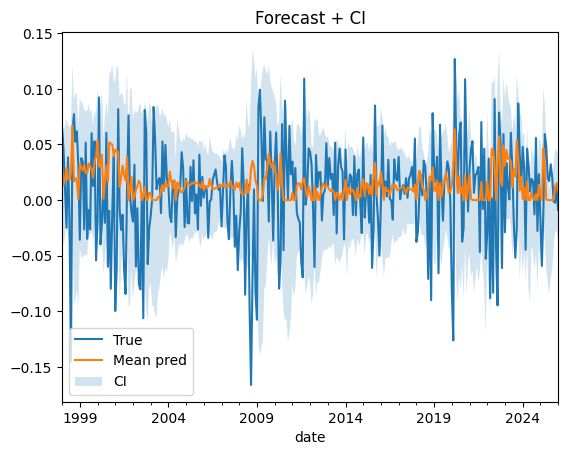

In [71]:
# Merge predictions back
df_eval = df.join(pred_df, how="inner")

# Quick plots
plt.figure()
df_eval["y_true"].plot(label="True")
df_eval["y_pred"].plot(label="Pred (CT)")
plt.legend()
plt.title("Forward equity premium: True vs Chronos-2 forecast")
plt.show()

plt.figure()
df_eval["y_true"].plot(label="True")
df_eval["y_pred"].plot(label="Mean pred")
plt.fill_between(df_eval.index, df_eval["y_lo"], df_eval["y_hi"], alpha=0.2, label="CI")
plt.legend()
plt.title("Forecast + CI")
plt.show()


In [72]:
# Backtest timing strategy
ppy = infer_periods_per_year(freq)
vol_window = 60 if ppy == 12 else (60 if ppy == 52 else 252)

bt = backtest_timing_strategy(
    df=df_eval,
    target_col="equity_premium",
    pred_col="y_pred",
    rf_col="Rfree",
    uselog=False,
    gamma=5.0,
    vol_window=vol_window,
    w_min=0.0,
    w_max=1.5,
    lag=0,
)

perf = compare_strategies(
    bt,
    r_excess_col="r_excess",
    gamma=5.0,
    vol_window=vol_window,
    periods_per_year=ppy,
)

perf


,TotalReturn,CAGR,AnnVol,Sharpe,MaxDrawdown,CEV,Δu vs HA,Δu vs 50%,Δu vs 100%
Strategy,,,,,,,,,
Model,4.638553,0.077808,0.180915,0.416323,-0.670326,-0.006437,-0.027136,-0.044801,-0.057323
HA,2.170648,0.051261,0.080091,0.458741,-0.181160,0.020699,NaN,NaN,NaN
W50,3.499806,0.067326,0.071909,0.713364,-0.280672,0.038363,NaN,NaN,NaN
W100,11.180327,0.114377,0.143702,0.713364,-0.506266,0.050886,NaN,NaN,NaN


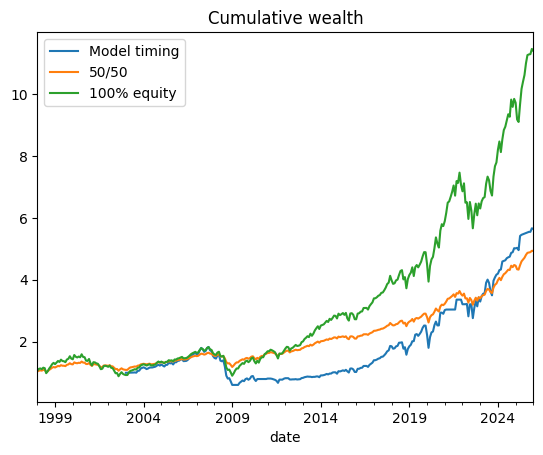

In [73]:
# Cumulative wealth curves
plt.figure()
(1 + bt["port_total"].dropna()).cumprod().plot(label="Model timing")
rf = bt["rf"]
r_excess = bt["r_excess"]
(1 + (rf + 0.5*r_excess).dropna()).cumprod().plot(label="50/50")
(1 + (rf + 1.0*r_excess).dropna()).cumprod().plot(label="100% equity")
plt.legend()
plt.title("Cumulative wealth")
plt.show()


In [75]:
freq = "MS"   # or "MS" if you want a more GW-like regime
df = build_dataset_spy_rich_real(
    start="1995-01-01",
    end=None,
    freq=freq,
    macro_release_lag=1,
    ffill_macro=True,
)

df2, covs = select_and_clean_covariates(
    df,
    target_col="equity_premium",
    min_non_na_share=0.98,
    drop_initial=0,
)

print("n obs:", df2.shape[0])
print("n covariates:", len(covs))
print(covs[:20], "...")
# choose ctx_min based on freq
if freq.upper() in ["MS", "M"]:
    ctx_min = 60
elif freq.upper().startswith("W"):
    ctx_min = 104
else:
    ctx_min = 252

pred_df, summary = chronos2_oos_real(
    data=df2,
    covariates=covs,
    target_col="equity_premium",
    start_oos="2005-01-01",
    ctx_min=ctx_min,
    ct_cutoff=True,
    model_id="amazon/chronos-2",
    ci=0.90,
    model_name=f"Chronos-2 SPY rich ({freq})",
    cov_style="future",
    quiet=False,
)

summary


n obs: 365
n covariates: 46
['Rfree', 'price', 'rf_level', 'y1', 'y2', 'y5', 'y10', 'tms_10y3m', 'tms_10y2y', 'cs_baa10y', 'cs_aaa10y', 'unrate', 'indpro', 'nfci', 'stlfsi', 'vix', 'rf_level_chg1', 'rf_level_chg4', 'y2_chg1', 'y2_chg4'] ...
[Chronos-2] Loading amazon/chronos-2 | device=mps | cov_style=future


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


2009-02-01 | n=50
2013-04-01 | n=100
2017-06-01 | n=150
2021-08-01 | n=200
2025-10-01 | n=250
[Chronos-2 SPY rich (MS) (CT)] OOS R2 = -0.0653 | 90% boot CI [-0.1006, -0.0245]
[Chronos-2 SPY rich (MS) (raw)] OOS R2 = -0.0904 | 90% boot CI [-0.1581, -0.0239]
Negative raw forecasts: 52/253 (20.55%)
Timing summary (CT): {'share_in_market': 0.7944664031620553, 'timing_spread': -0.007041019020739344}


{'r2_ct': -0.06534300925664982,
 'stats_ct': {'mean': -0.06318828690085396,
  'std': 0.023174624386263803,
  'lower': -0.10063345185776193,
  'upper': -0.024471810352760682},
 'r2_raw': -0.09042132854582197,
 'stats_raw': {'mean': -0.09000277610616286,
  'std': 0.04053251740259346,
  'lower': -0.15812173944314495,
  'upper': -0.023864312475113992},
 'n_oos': 253,
 'truncated_count': 52,
 'timing': {'share_in_market': 0.7944664031620553,
  'timing_spread': -0.007041019020739344}}

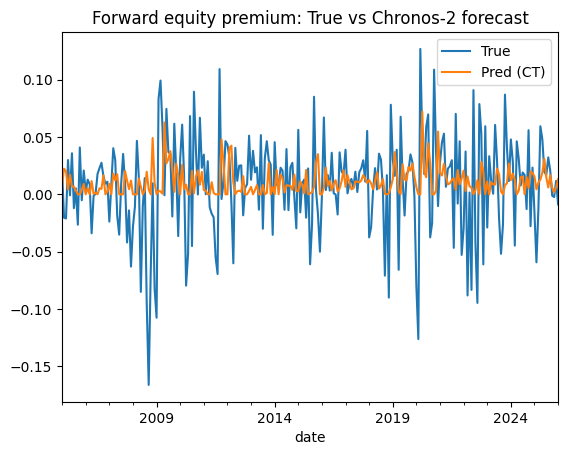

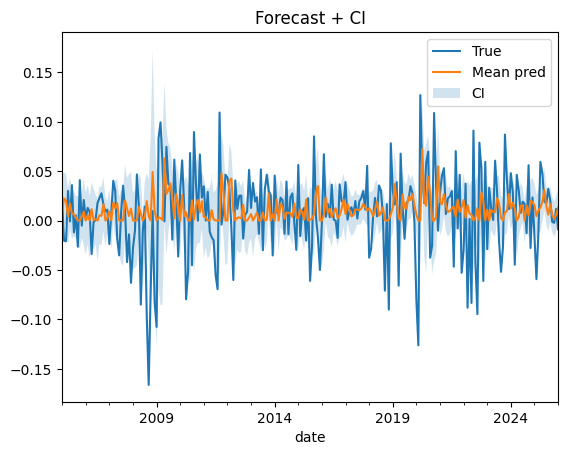

In [76]:
# Merge predictions back
df_eval = df.join(pred_df, how="inner")

# Quick plots
plt.figure()
df_eval["y_true"].plot(label="True")
df_eval["y_pred"].plot(label="Pred (CT)")
plt.legend()
plt.title("Forward equity premium: True vs Chronos-2 forecast")
plt.show()

plt.figure()
df_eval["y_true"].plot(label="True")
df_eval["y_pred"].plot(label="Mean pred")
plt.fill_between(df_eval.index, df_eval["y_lo"], df_eval["y_hi"], alpha=0.2, label="CI")
plt.legend()
plt.title("Forecast + CI")
plt.show()


In [80]:
# Backtest timing strategy
ppy = infer_periods_per_year(freq)
vol_window = 60 if ppy == 12 else (60 if ppy == 52 else 252)

bt = backtest_timing_strategy(
    df=df_eval,
    target_col="equity_premium",
    pred_col="y_pred",
    rf_col="Rfree",
    uselog=False,
    gamma=3.0,
    vol_window=vol_window,
    w_min=0.0,
    w_max=1.5,
    lag=0,
)

perf = compare_strategies(
    bt,
    r_excess_col="r_excess",
    gamma=5.0,
    vol_window=vol_window,
    periods_per_year=ppy,
)

perf


,TotalReturn,CAGR,AnnVol,Sharpe,MaxDrawdown,CEV,Δu vs HA,Δu vs 50%,Δu vs 100%
Strategy,,,,,,,,,
Model,5.083614,0.118810,0.142587,0.767211,-0.414935,0.058553,0.013109,0.006079,-0.021125
HA,2.928806,0.088802,0.114751,0.683061,-0.212503,0.045444,NaN,NaN,NaN
W50,2.402404,0.079107,0.071287,0.915844,-0.121965,0.052474,NaN,NaN,NaN
W100,7.512125,0.142421,0.142284,0.915844,-0.240941,0.079678,NaN,NaN,NaN


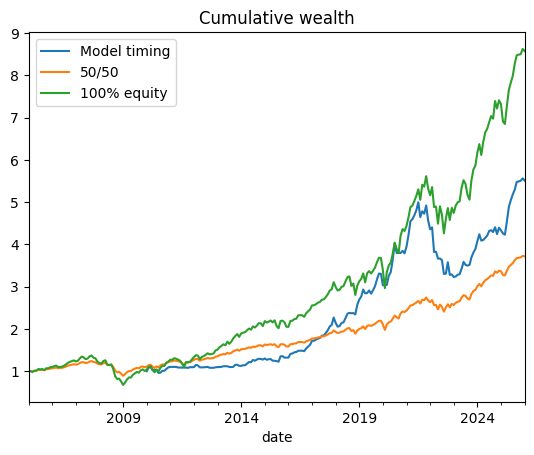

In [79]:
# Cumulative wealth curves
plt.figure()
(1 + bt["port_total"].dropna()).cumprod().plot(label="Model timing")
rf = bt["rf"]
r_excess = bt["r_excess"]
(1 + (rf + 0.5*r_excess).dropna()).cumprod().plot(label="50/50")
(1 + (rf + 1.0*r_excess).dropna()).cumprod().plot(label="100% equity")
plt.legend()
plt.title("Cumulative wealth")
plt.show()
